## Chapter 11: Miscelleneous Problems in Image Processing and Computer Vision

## Problems

1. **Deep Dreaming** with `pytorch`
2. **Neural Style Transfer** (**NST**) using Perceptual Losses      
   2.1: with Pre-trained `pytorch` model       
   2.2: Real-Time Style Transfer with pre-trained `pytorch` onnx model       
   2.3: Fast Style Transfer for Arbitrary Styles with `tensorflow hub`

3. **Image Colorization** with Pre-trained `pytorch` models    
   3.1: with **DeOldify**       
   3.2: with Colorful Image Colorization (**CIC**)

4. Visualizing **VGG16** features in 2D with **t-SNE** and classifying with **SVM**  
5. Creating **Point Cloud** from images    
   5.1: Creating depth map from a color image using dense prediction with vision transformers (**MiDaS**)       
   5.2: Creating point cloud from depth map with Open3D       
6. **Augmented Reality** with `opencv-python`
7. Embedding and playing video clips in different regions of an image with `moviepy`
8. Generating Bird Images from Text with **GAN-CLS**
9. Image Editing with **Seamless Cloning**
10. Text to Image Generation and Image Editing with **Dall-E** **OpenAI** API   
   10.1 **Zero-shot** Text-to-image generation       
   10.2 Editing Image with mask

## Problem 1: Deep Dreaming with Pytorch

In [7]:
import torch
from torchvision import transforms, models
from torch.autograd import Variable
from IPython.display import clear_output
from PIL import Image
import scipy.ndimage as ndimage
import numpy as np
import matplotlib.pylab as plt

In [ ]:
def show_image_tensor(img):
    mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
    std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
    img = img[0].transpose(1, 2, 0)
    img = std * img + mean
    img = np.clip(np.uint8(img*255), 0, 255)
    plt.figure(figsize=(15,15))
    plt.imshow(img), plt.axis('off'), plt.title('Guided Deep Dream', size=20)
    plt.show()
    clear_output(wait=True)

In [ ]:
def forward(model, x, end):
    layers = list(model.features.children())
    last = len(layers)
    for index in range(min(end, last)):
        model = layers[index]
        x = model(x)
    return x    

def objective_func(activations, guide_features):
    x, y = activations.data[0].cpu().numpy(), guide_features.data[0].cpu().numpy()
    ch, w, h = x.shape
    x, y = x.reshape(ch, -1), y.reshape(ch, -1)
    sim = x.T.dot(y)
    diff = y[:, sim.argmax(1)]
    diff = torch.Tensor(np.array([diff.reshape(ch, w, h)]))
    return diff

def step_next(img, model, guide, end_layer=30, distance=objective_func, 
              max_jitter = 30, learning_rate = 0.05, num_iterations = 20, show_every = 10):
   
    mean = np.array([0.485, 0.456, 0.406]).reshape([3, 1, 1])
    std = np.array([0.229, 0.224, 0.225]).reshape([3, 1, 1])

    for i in range(num_iterations):
        
        shift_x, shift_y = np.random.randint(-max_jitter, max_jitter + 1, 2)
        img = np.roll(np.roll(img, shift_x, -1), shift_y, -2)
        
        model.zero_grad()
        img_tensor = torch.Tensor(img)
        guide_tensor = torch.Tensor(guide)
        
        if torch.cuda.is_available():
            img_tensor = img_tensor.cuda()
            guide_tensor = guide_tensor.cuda()
        
        img_variable = Variable(img_tensor, requires_grad=True)
        guide_variable = Variable(guide_tensor, requires_grad=True)

        act_value = forward(model, img_variable, end_layer)
        guide_features = forward(model, guide_variable, end_layer)
        
        diff_out = distance(act_value, guide_features)
        act_value.backward(diff_out)
        
        ratio = np.abs(img_variable.grad.data.cpu().numpy()).mean()
        learning_rate_eff = learning_rate / ratio
        img_variable.data.add_(img_variable.grad.data * learning_rate_eff)
        
        img = img_variable.data.cpu().numpy()  # b, c, h, w
        img = np.roll(np.roll(img, -shift_x, -1), -shift_y, -2)
        img[0, :, :, :] = np.clip(img[0, :, :, :], -mean / std, (1 - mean) / std)
        
        if i == 0 or (i + 1) % show_every == 0:
            show_image_tensor(img)
            
    return img

In [ ]:
def deep_dream(model,
          base_img,
          end_layer=30,
          octave_n=6,
          octave_scale=1.4,
          control=None,
          distance=objective_func):
    
    octaves = [base_img]
    for i in range(octave_n - 1):
        octaves.append(ndimage.zoom(octaves[-1], (1, 1, 1.0 / octave_scale, 1.0 / octave_scale),  order=1))
    
    detail = np.zeros_like(octaves[-1])
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        if octave > 0:
            h1, w1 = detail.shape[-2:]
            detail = ndimage.zoom(detail, (1, 1, 1.0 * h / h1, 1.0 * w / w1), order=1)
        input_oct = octave_base + detail
        out = step_next(input_oct, model, control, end_layer=end_layer, distance=distance)
        detail = out - octave_base
        
model = models.vgg16(pretrained=True)
#model # print the model structure

In [43]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_img = np.array(Image.open('images/Img_02_24.jpg'))
guide_img = np.array(Image.open('images/cat.jpg'))
input_tensor = img_transform(input_img).unsqueeze(0)
guide_tensor = img_transform(guide_img).unsqueeze(0)

The following figure shows the input image (from the TV show Big Bang Theory) and the control (guide) image (a cat) that we are going to use.

<img src="images/dd_input_guide.png" width="500"/>

In [44]:
if torch.cuda.is_available():
    model = model.cuda()
for param in model.parameters():
    param.requires_grad = False

In [ ]:
deep_dream(model, input_tensor.numpy(), 8, control=guide_tensor.numpy())   # layer 8
deep_dream(model, input_tensor.numpy(), 26, control=guide_tensor.numpy())  # layer 26

<img src="images/guided_deep_dream_out.png" width="500"/>

## Problem 2: Neural Style Transfer with Perceptual Losses

### 2.1: using Pre-trained Pytorch model

In [6]:
import cv2
import torch.nn.functional as F
import torchnet as tnt
import torchfile
from skimage.io import imread
import os, time

In [7]:
def forward(x, params):
    def g(f, y, name, stride=1, padding=0):
        return f(y, params['%s.weight'%name], params['%s.bias'%name], stride, padding)
    x = F.relu(g(F.conv2d, x, 'c1', 1, 4))
    x = F.relu(g(F.conv2d, x, 'c2', 2, 1))
    x = F.relu(g(F.conv2d, x, 'c3', 2, 1))
    for i in range(1, 6):
        x += g(F.conv2d, F.relu(g(F.conv2d, x, 'r%d.c1'%i, padding=1)), 'r%d.c2'%i, padding=1)
    x = F.relu(g(F.conv_transpose2d, x, 'd1', 2, 1))
    x = F.relu(g(F.conv_transpose2d, x, 'd2', 2, 1))
    return g(F.conv2d, x, 'd3', 1, 4).clamp(0,255)

tr = tnt.transform.compose([
        lambda x: cv2.resize(x, (0,0), fx=0.5, fy=0.5),
        lambda x: x.transpose(2, 0, 1).astype(np.float32),
        torch.from_numpy,
        lambda x: x.contiguous().unsqueeze(0),
    ])

def stylize(im, params):
    return forward(Variable(tr(im)), params)

def load_params(filename, verbose=False):
    params = torch.load(filename)
    for k,v in sorted(params.items()):
        params[k] = Variable(v) #, requires_grad=True)
    return params

[INFO] neural style transfer took 1.6850 seconds
[INFO] neural style transfer took 1.6790 seconds
[INFO] neural style transfer took 1.6181 seconds


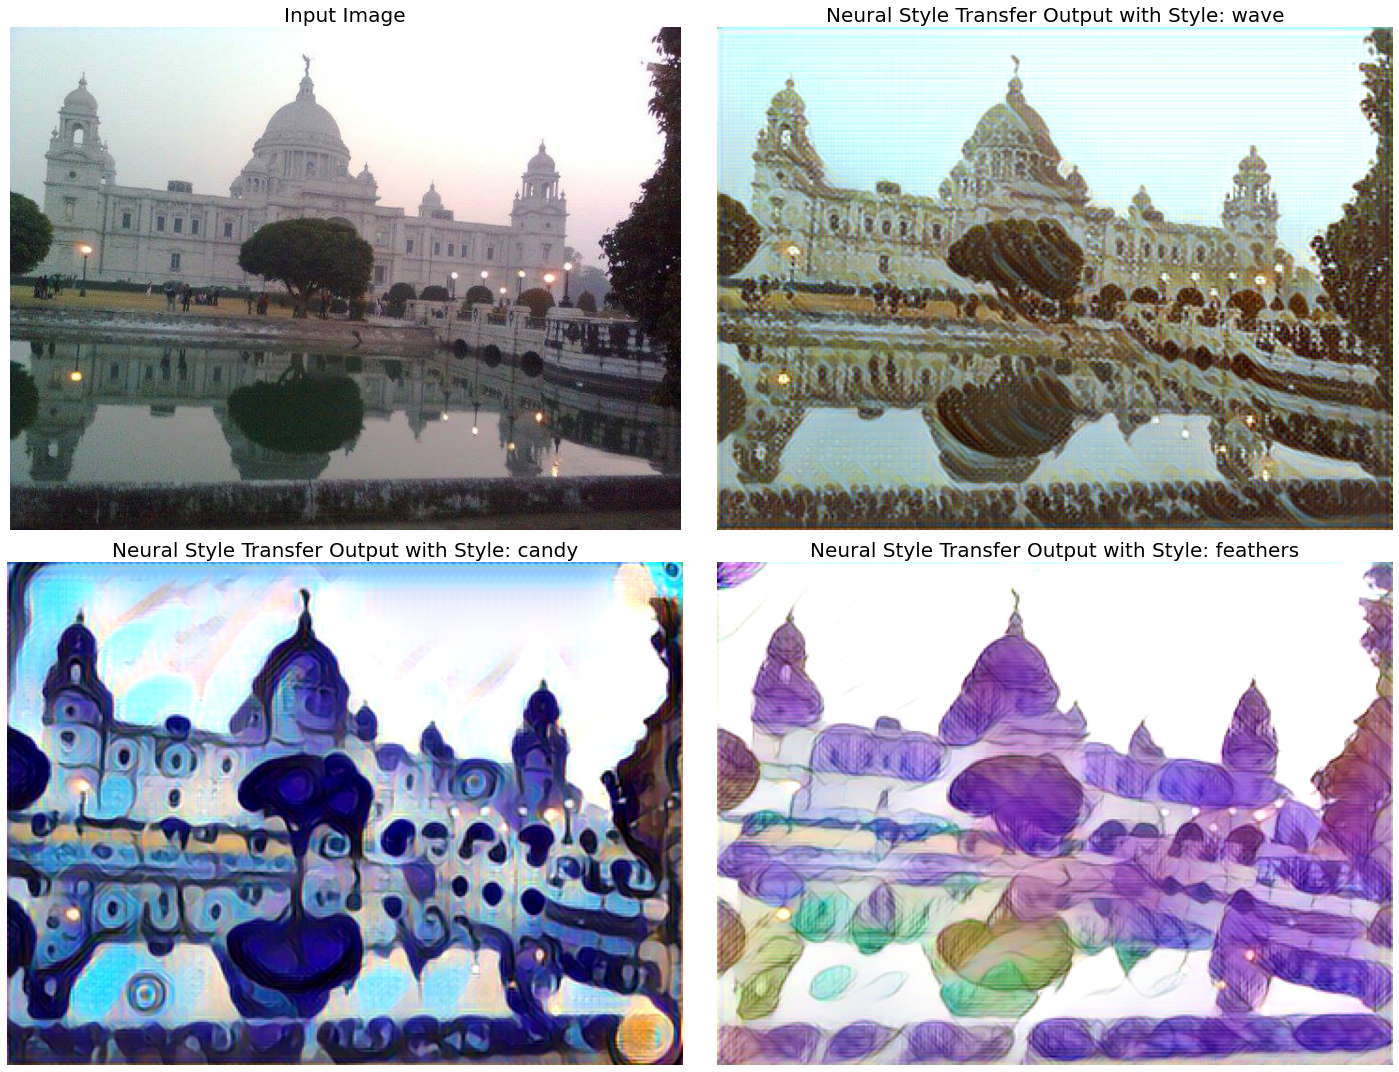

In [9]:
styles = ['wave', 'candy', 'feathers']
model_path = 'models/'
models = ['wave.pth', 'candy.pth', 'feathers.pth']

tr_backward = tnt.transform.compose([
        lambda x: x.byte().numpy(),
        lambda x: x.transpose(1,2,0),
    ])

im = imread('images/Img_02_11.jpg')

def plot_image(im, title):
    plt.imshow(im), plt.axis('off')
    plt.title(title, size=20)

plt.figure(figsize=(20,15))
plt.subplot(2,2,1), plot_image(im, 'Input Image')

for k in range(len(models)):
    params = load_params(os.path.join(model_path, models[k]))
    start = time.time()
    stylized = stylize(im, params)
    output = tr_backward(stylized.data[0])                             
    end = time.time()                         
    print("[INFO] neural style transfer took {:.4f} seconds".format(end - start))    
    plt.subplot(2,2,k+2), plot_image(output, 'Neural Style Transfer Output with Style: ' + styles[k])
plt.tight_layout()    
plt.show()

### 2.2: Real-Time Style Transfer with pytorch onnx model

In [19]:
#!pip install onnxruntime
import onnxruntime

content_image = plt.imread('images/Img_02_04.jpg')
x = cv2.resize(content_image, (224,224))
x = np.array(x).astype('float32')
x = np.transpose(x, [2, 0, 1])
x = np.expand_dims(x, axis=0)
ort_session = onnxruntime.InferenceSession('models/mosaic-9.onnx')
ort_inputs = {ort_session.get_inputs()[0].name: x}
ort_outs = ort_session.run(None, ort_inputs)
img_out_y = ort_outs[0].squeeze()
result = np.clip(img_out_y, 0, 255)
result = result.transpose(1,2,0).astype("uint8")
stylized_image = Image.fromarray(result)

<img src="images/style_out_onnx.png" width="500"/>

### 2.3: Fast Style Transfer for Arbitrary Styles with Tensorflow Hub

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)      # 2.8.0
print("TF-Hub version: ", hub.__version__) # 0.9.0
print("Eager mode enabled: ", tf.executing_eagerly()) # True
print("GPU available: ", tf.test.is_gpu_available())  # False

In [ ]:
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

In [16]:
def load_image(image_path, image_size=(256, 256), preserve_aspect_ratio=True):
  img = plt.imread(image_path).astype(np.float32)[np.newaxis, ...]
  img = img / img.max()
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

content_image = load_image('images/Img_02_04.jpg', (512,512))
style_image = load_image('images/bharatmata.png')
#style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')

In [17]:
start = time.time()
outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]
print('Time taken to run inference: {}'.format(time.time() - start))

Time taken to run inference: 5.438430309295654


<img src="images/style_out_tfhub.png" width="500"/>

## Problem 3: Image Colorization with pre-trained Pytorch models

### 3.1: with DeOldify

In [ ]:
!git clone https://github.com/jantic/DeOldify.git DeOldify 
%cd DeOldify

In [35]:
#!pip install ffmpeg-python
#!pip install yt_dlp
from deoldify import device
from deoldify.device_id import DeviceId
device.set(device=DeviceId.CPU)
from deoldify.visualize import *

In [ ]:
colorizer = get_image_colorizer(artistic=True)
#%cd ..

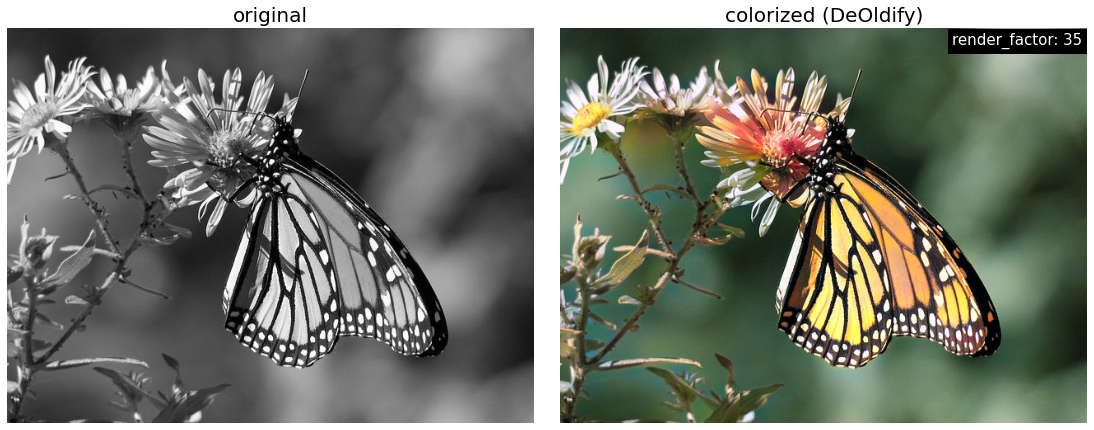

In [33]:
render_factor = 35  #@param {type: "slider", min: 7, max: 40}
watermarked = True #@param {type:"boolean"}
imfile = '../images/Img_02_12.jpg'
out_img_deoldify = colorizer.get_transformed_image(imfile, render_factor=render_factor, watermarked=watermarked)

plt.figure(figsize=(15,7))
plt.gray()
plt.subplots_adjust(0, 0, 1, 0.95, 0.05, 0.05)
plt.subplot(121), plt.imshow(plt.imread(imfile)), plt.axis('off'), plt.title('original', size=20)
plt.subplot(122), plt.imshow(out_img_deoldify), plt.axis('off'), plt.title('colorized (DeOldify)', size=20)
plt.rcParams.update({'font.size': 15,})
plt.text(475, 20, 'render_factor: ' + str(render_factor), color='white', backgroundcolor='black')
plt.show()

### 3.2: with Colorful Image Colorization (CIC)

In [ ]:
!git clone https://github.com/richzhang/colorization.git
#!pip install requirements.txt
%cd colorization

In [ ]:
from colorizers import *
colorizer_eccv16 = eccv16(pretrained=True).eval()
colorizer_siggraph17 = siggraph17(pretrained=True).eval()
if torch.cuda.is_available():
    colorizer_eccv16.cuda()
    colorizer_siggraph17.cuda()
img = load_img(imfile)[...,:3]
(tens_l_orig, tens_l_rs) = preprocess_img(img, HW=(256,256))
if torch.cuda.is_available():
    tens_l_rs = tens_l_rs.cuda()

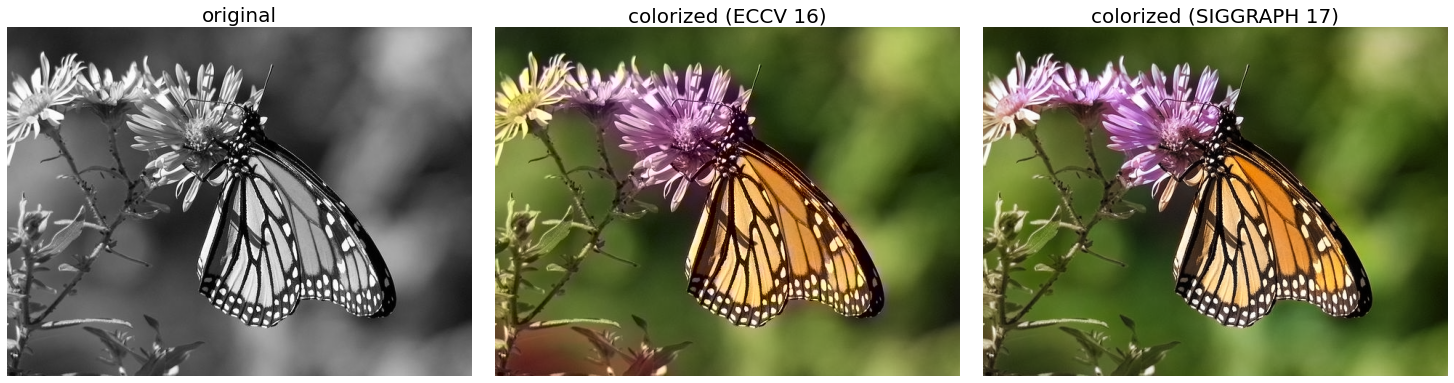

In [34]:
out_img_eccv16 = postprocess_tens(tens_l_orig, colorizer_eccv16(tens_l_rs).cpu())
out_img_siggraph17 = postprocess_tens(tens_l_orig, colorizer_siggraph17(tens_l_rs).cpu())

plt.figure(figsize=(20,7))
plt.subplots_adjust(0, 0, 1, 0.95, 0.05, 0.05)
plt.subplot(131), plt.imshow(img), plt.axis('off'), plt.title('original', size=20)
plt.subplot(132), plt.imshow(out_img_eccv16), plt.axis('off'), plt.title('colorized (ECCV 16)', size=20)
plt.subplot(133), plt.imshow(out_img_siggraph17), plt.axis('off'), plt.title('colorized (SIGGRAPH 17)', size=20)
plt.show()

## Problem 4: Visualizing VGG16 features in 2D with t-SNE and classifying with SVM

In [3]:
#! pip install kaggle
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#! kaggle competitions download -c dogs-vs-cats
#! unzip dogs*.zip
#! unzip train.zip

In [ ]:
import tensorflow
import tensorflow.keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import matplotlib.pylab as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import pandas as pd
from glob import glob
from random import choices

In [ ]:
model = VGG16(weights='imagenet', include_top=True)
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
# feat_extractor.summary()

In [ ]:
n = 1024
np.random.seed(1)
labels = ['cat']*n + ['dog']*n
images = np.random.choice(glob('train/cat*.jpg'), n, replace=False).tolist() + \
         np.random.choice(glob('train/dog*.jpg'), n, replace=False).tolist()
len(images)
# 2048

In [ ]:
x = np.zeros((len(images),224,224,3))
for i in range(len(images)):
    x[i] = image.load_img(images[i], target_size=(224,224))
feats = feat_extractor.predict(x)
print(feats.shape)
# (2048, 4096)

In [11]:
tsne = TSNE(n_components=2, learning_rate='auto',  init='random', perplexity=3).fit_transform(np.array(feats))
df = pd.DataFrame({'tsne-2d-one': tsne[:,0], 'tsne-2d-two': tsne[:,1], 'label': labels})
df.head()

tsne-2d-one  tsne-2d-two label
0    15.748092     9.109365   cat
1    19.970919   -15.171882   cat
2    33.246052    10.163391   cat
3    11.935716    -7.471368   cat
4    34.340569    -4.774371   cat

In [ ]:
X = df.values
X = X[:, :2]
y = df.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = SVC(kernel="linear").fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred))

In [ ]:
plt.figure(figsize=(20,20))
ax = plt.gca()
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.7)
artists = []
x, y = np.atleast_1d(df['tsne-2d-one'].values, df['tsne-2d-two'].values)
for i, row in df.iterrows():
    if random() > 0.95: # plot images 5% of the times
      ab = AnnotationBbox(OffsetImage(cv2.resize(plt.imread(images[i]), (50,50)), zoom=1), 
                          (row['tsne-2d-one'], row['tsne-2d-two']), xycoords='data', frameon=False)
      artists.append(ax.add_artist(ab))
ax.update_datalim(np.column_stack([x, y]))
ax.autoscale()

<img src="images/vgg_svm_tsne.png" width="500"/>

## Problem 5: Creating Point Cloud from images

### 5.1 Creating depth map from a color image using dense prediction with vision transformers (MiDaS)

In [23]:
import open3d as o3d
import torch
import cv2
from glob import glob
import matplotlib.pylab as plt

In [ ]:
#! pip install timm

model_type = "DPT_Large"     

for filename in glob('images/pcl/input/*.jpg'):

  img = cv2.imread(filename)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  midas = torch.hub.load("intel-isl/MiDaS", model_type)

  device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
  midas.to(device)
  midas.eval()

  midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

  transform = midas_transforms.dpt_transform   
  input_batch = transform(img).to(device)

  with torch.no_grad():
      prediction = midas(input_batch)
      prediction = torch.nn.functional.interpolate(
          prediction.unsqueeze(1),
          size=img.shape[:2],
          mode="bicubic",
          align_corners=False,
      ).squeeze()

  output = prediction.cpu().numpy()
  img = img / img.max()
  output = cv2.normalize(output, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  plt.imsave('images/pcl/col_{}'.format(filename.split('/')[-1]), img)
  plt.imsave('images/pcl/depth_{}'.format(filename.split('/')[-1]), output)

### 5.2 Creating point cloud from depth map with *Open3D*

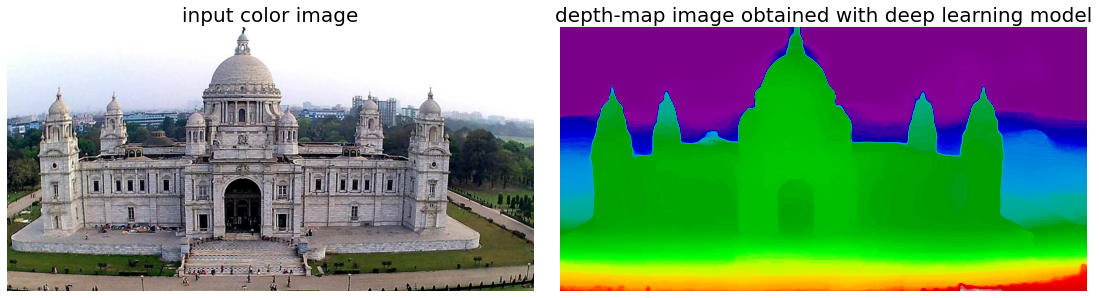

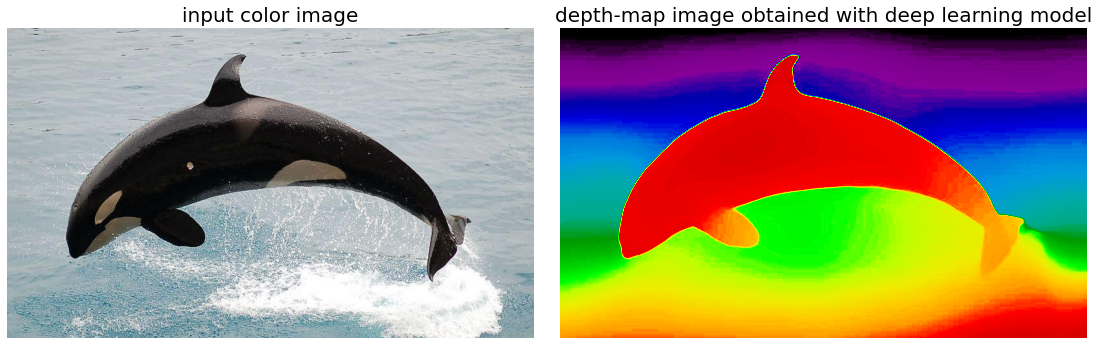

In [3]:
for imf in ['victoria', 'whale']:
    im = plt.imread("images/pcl/col_{}.jpg".format(imf))
    color_raw = o3d.io.read_image("images/pcl/col_{}.jpg".format(imf))
    depth_raw = o3d.io.read_image("images/pcl/depth_{}.jpg".format(imf))
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw)
    plt.figure(figsize=(15,10))
    plt.subplots_adjust(0,0,1,0.95,0.05,0.05)
    plt.subplot(121), plt.title('input color image', size=20), plt.imshow(im), plt.axis('off')
    plt.subplot(122), plt.title('depth-map image obtained with deep learning model', size=20)
    plt.imshow(rgbd_image.depth, cmap='nipy_spectral'), plt.axis('off')
    plt.show()

In [35]:
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)
print(camera_intrinsic.intrinsic_matrix)

[[525.    0.  319.5]
 [  0.  525.  239.5]
 [  0.    0.    1. ]]


In [4]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)  
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd)
o3d.visualization.ViewControl.set_zoom(vis.get_view_control(), 0.5)
vis.run()

<img src="images/pcl/pcl_victoria.png" width="500"/>
<img src="images/pcl/pcl_whale.png" width="500"/>

## Problem 6: Augmented Reality with opencv-python

In [135]:
import numpy as np
import cv2
import matplotlib.pylab as plt
from IPython.display import display, Image

In [143]:
marker, model3d = 'images/book_cover.jpg', 'models/horse.obj' #Img_08_10.jpg

<img src="images/book_cover_model.png" width="500"/>

<img src="images/obj.png" width="500"/>

In [137]:
class OBJ:
    def __init__(self, filename, swapyz=False):
        self.vertices = []
        self.normals = []
        self.texcoords = []
        self.faces = []
        for line in open(filename, "r"):
            if line.startswith('#'): continue
            values = line.split()
            if not values: continue
            if values[0] == 'v':
                v = list(map(float, values[1:4]))
                if swapyz:
                    v = v[0], v[2], v[1]
                self.vertices.append(v)
            elif values[0] == 'vn':
                v = list(map(float, values[1:4]))
                if swapyz:
                    v = v[0], v[2], v[1]
                self.normals.append(v)
            elif values[0] == 'vt':
                self.texcoords.append(map(float, values[1:3]))
            elif values[0] == 'f':
                face = []
                texcoords = []
                norms = []
                for v in values[1:]:
                    w = v.split('/')
                    face.append(int(w[0]))
                    if len(w) >= 2 and len(w[1]) > 0:
                        texcoords.append(int(w[1]))
                    else:
                        texcoords.append(0)
                    if len(w) >= 3 and len(w[2]) > 0:
                        norms.append(int(w[2]))
                    else:
                        norms.append(0)
                self.faces.append((face, norms, texcoords))

In [138]:
def render(frame, obj, projection, marker, feature_pts):
    
    for pt in np.reshape(feature_pts.astype('int32'), (-1,2)):
        frame = cv2.circle(frame, pt, 1, (0,0,255), 2)    
    
    vertices = obj.vertices
    scale_matrix = np.eye(3) # * 3
    h, w = marker.shape

    for face in obj.faces:
        face_vertices = face[0]
        points = np.array([vertices[vertex - 1] for vertex in face_vertices])
        points = np.dot(points, scale_matrix)
        points = np.array([[p[0] + w / 2, p[1] + h / 2, p[2]] for p in points])
        dst = cv2.perspectiveTransform(points.reshape(-1, 1, 3), projection)
        cv2.fillConvexPoly(frame, np.int32(dst), (135,181,222)) #(112,159,199) #(19,69,139))

    return frame

In [151]:
def compute_projection_matrix(A, H):
    
    H = H * (-1)
    R_t = np.dot(np.linalg.inv(A), H)
    R_1, R_2, R_3 = R_t[:, 0], R_t[:, 1], R_t[:, 2]
    l = np.sqrt(np.linalg.norm(R_1, 2) * np.linalg.norm(R_2, 2))
    R_1, R_2, t = R_1 / l, R_2 / l, R_3 / l
    c = R_1 + R_2
    p = np.cross(R_1, R_2)
    d = np.cross(c, p)
    R_1 = np.dot(c / np.linalg.norm(c, 2) + d / np.linalg.norm(d, 2), 1 / np.sqrt(2))
    R_2 = np.dot(c / np.linalg.norm(c, 2) - d / np.linalg.norm(d, 2), 1 / np.sqrt(2))
    R_3 = np.cross(R_1, R_2)
    projection = np.stack((R_1, R_2, R_3, t)).T
    return np.dot(A, projection)

In [147]:
min_matches = 10  
camera_parameters = np.array([[800, 0, 320], [0, 800, 240], [0, 0, 1]])

def add_augmented_reality(marker, model3d, max_num_frames=100):
    
    obj = OBJ(model3d, swapyz=True)
    marker = cv2.imread(marker, 0)    
    orb = cv2.ORB_create()
    kp_marker, des_marker = orb.detectAndCompute(marker, None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    cap = cv2.VideoCapture(0)
    display_handle=display(None, display_id=True)
    num_frames = 0    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Unable to capture video")
                return 
            in_frame = frame.copy()
            kp_frame, des_frame = orb.detectAndCompute(frame, None)
            matches = bf.match(des_marker, des_frame)
            matches = sorted(matches, key=lambda x: x.distance)
            if len(matches) > min_matches:
                src_pts = np.float32([kp_marker[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
                dst_pts = np.float32([kp_frame[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
                homography, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)                
                if homography is not None:
                    try:
                        projection = compute_projection_matrix(camera_parameters, homography)  
                        frame = render(frame, obj, projection, marker, dst_pts[mask])
                    except Exception as err:
                        print(err) 
                        pass
                    
                cv2.imwrite('ar/input/frame_{:03d}.jpg'.format(num_frames), in_frame)
                cv2.imwrite('ar/output/frame_{:03d}.jpg'.format(num_frames), frame)
                out_frame = np.concatenate((in_frame, frame), axis=1)
                
                _, out_frame = cv2.imencode('.jpeg', out_frame)
                display_handle.update(Image(data=out_frame.tobytes()))

                if num_frames > max_num_frames: break
                num_frames += 1
            else:
                print("Not enough matches found: {}/{}" .format(len(matches), min_matches)) 

    except KeyboardInterrupt:
        pass
    finally:
        cap.release()
        display_handle.update(None)

In [ ]:
add_augmented_reality(marker, model3d)

<img src="images/ar_input_output.png" width="500"/>

<img src="images/ar_outputs.png" width="500"/>

## Problem 7: Embedding and playing video clips in different regions of an image with `moviepy`

In [1]:
# ! pip install moviepy
from moviepy.editor import *
from moviepy.video.tools.segmenting import findObjects
from moviepy.video.tools.subtitles import SubtitlesClip
import cv2
import numpy as np
import matplotlib.pylab as plt
from glob import glob

In [ ]:
image = "images/Img_08_09.png"
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)), plt.axis('off')
plt.title('Original image', size=25)
plt.show()

In [17]:
im = ImageClip(image)
regions = findObjects(im)
print(len(regions), im.size)
#print([(r.screenpos, r.size) for r in regions]) #, r.mask

video_files = sorted(glob('images/vid/in/V*.mp4'))[:5]

5 (930, 773)


In [4]:
def create_subtitle_file():
    with open('images/vid/out/subtitles.srt', 'w') as f:
        for i in range(20):
            f.write('{}\n00:00:{:02d},000 --> 00:00:{:02d},000\nComposite video subtitle {}\n\n'.format(i+1, i, i+1, i+1))
            
create_subtitle_file()

In [ ]:
frame_rate = 20
n_secs = 20
clips = [VideoFileClip(vf, audio=False).subclip(0, n_secs).set_fps(frame_rate) for vf in video_files] 

comp_clips =  [c.resize(r.size)
                .set_mask(r.mask)
                .set_pos(r.screenpos)
               for c,r in zip(clips,regions[:len(clips)])]
#print(len(comp_clips))

generator = lambda txt: TextClip(txt, font='Georgia-Regular', fontsize=24, color='white')
subtititles = SubtitlesClip("images/vid/out/subtitles.srt", generator)

cc = CompositeVideoClip(comp_clips + [subtititles.set_pos(('center','bottom'))], size=im.size)
cc.resize(0.6).write_videofile("images/vid/out/composition.mp4", fps=frame_rate) #, audio_codec="aac") #
for i in range(len(clips)):
    clips[i].write_videofile('images/vid/out/Vid_{:02d}.mp4'.format(i))
    clips[i].reader.close()
    
video_files += ["images/vid/out/composition.mp4"]   

In [ ]:
video_clips = sorted(glob('images/vid/out/V*.mp4'))
min_len = np.inf
for c in video_clips:
    clip = VideoFileClip(c)
    num_frames = int(clip.fps * clip.duration)
    print(clip.fps, num_frames)
    # 20.0 400
    min_len = min(min_len, num_frames) 
    clip.reader.close()  
print(min_len)
# 400

230


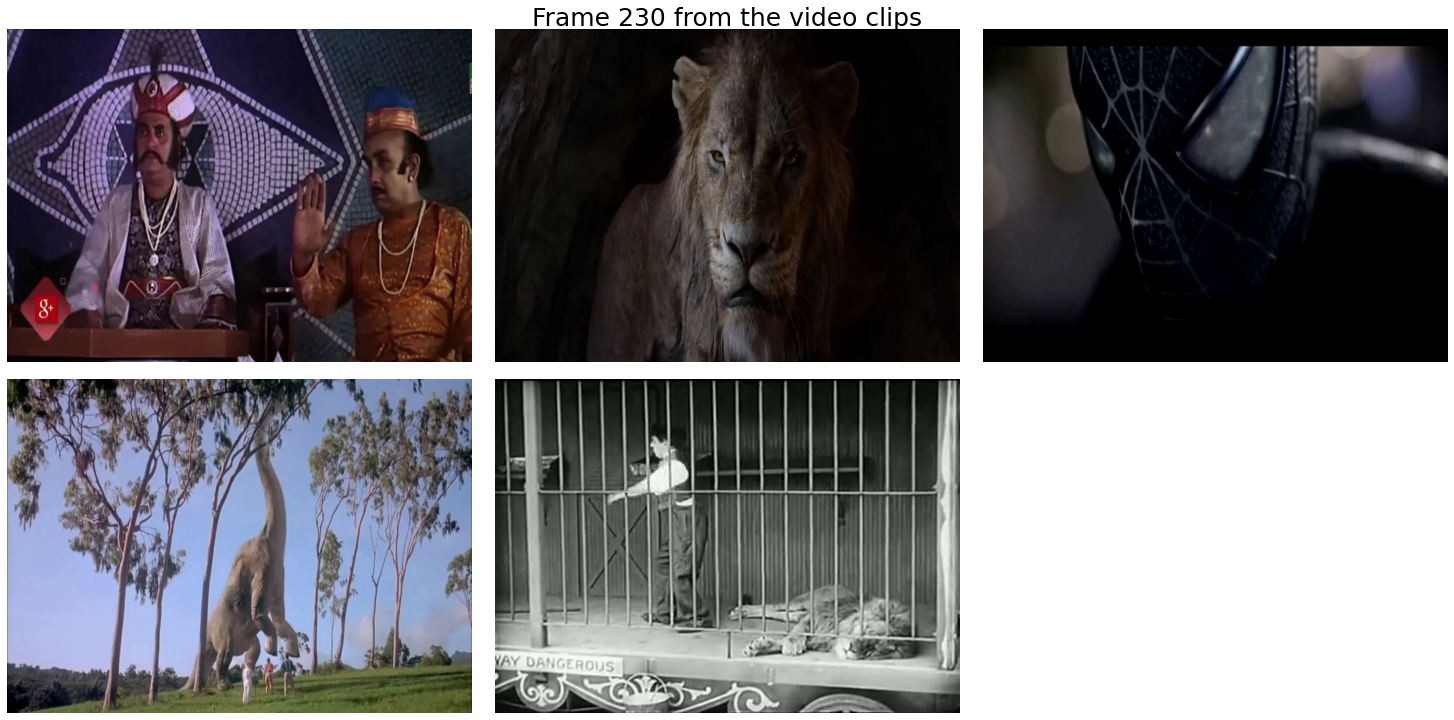

744.0 618.0 20.0 400.0


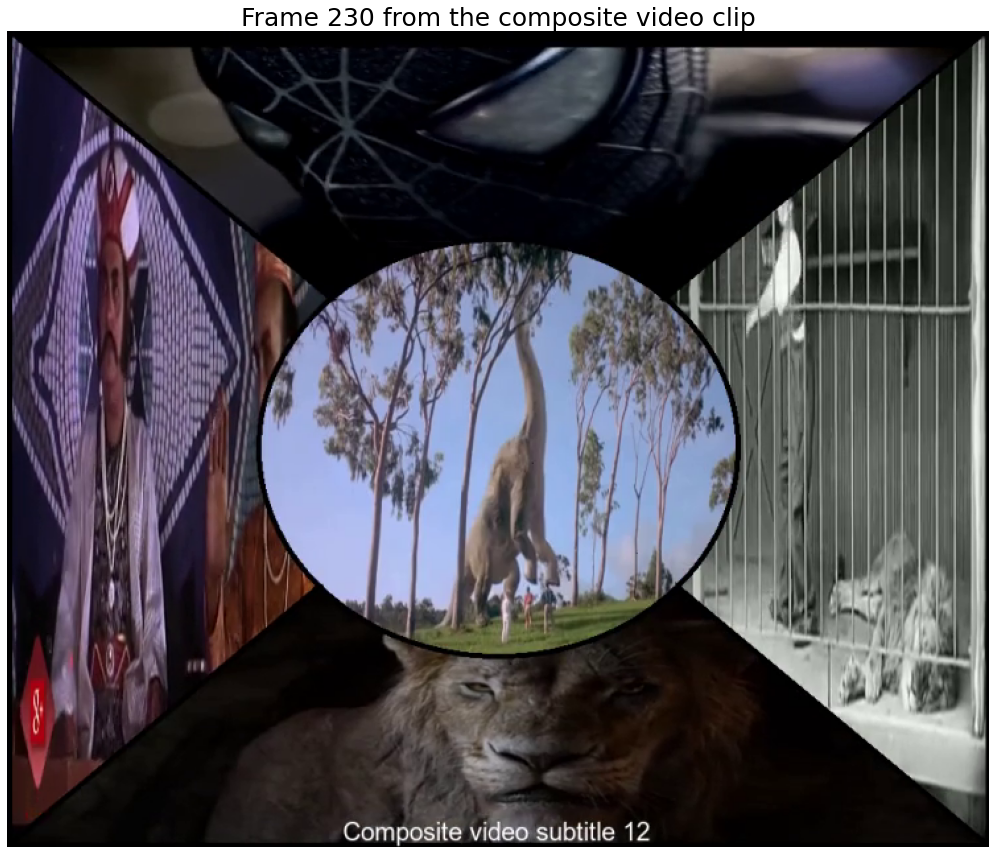

In [78]:
index = np.random.choice(min_len, 1)[0]
print(index)
plt.figure(figsize=(20,10))
plt.subplots_adjust(0,0,1,0.95,0.05,0.05)
i = 1
for vid in video_clips:
    cap = cv2.VideoCapture(vid)
    cap.set(cv2.CAP_PROP_POS_FRAMES, index)
    _, frame = cap.read()
    plt.subplot(2,3,i), plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), aspect='auto'), plt.axis('off')
    i += 1
    cap.release()
plt.suptitle('Frame {} from the video clips'.format(index), size=25)
plt.show()
cap = cv2.VideoCapture('images/vid/out/composition.mp4')
width  = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT) 
fps = cap.get(cv2.CAP_PROP_FPS) 
total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
print(width, height, fps, total_frames)
cap.set(cv2.CAP_PROP_POS_FRAMES, index)
_, frame = cap.read()
#frame = clip.get_frame(index)
plt.figure(figsize=(20,15))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)), plt.axis('off')
plt.title('Frame {} from the composite video clip'.format(index), size=25)
plt.show()     

## Problem 8: Generating Bird Images from Text with GAN-CLS

In [2]:
import tensorflow as tf
print(tf.__version__)
#from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.utils import array_to_img
import nltk
from nltk.tokenize import word_tokenize
import gensim

2.8.0


In [ ]:
nltk.download('punkt')
# download the model from here: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g and uncompress inside models folder
model = gensim.models.KeyedVectors.load_word2vec_format('models/GoogleNews-vectors-negative300.bin', binary=True)
gen_model = tf.keras.models.load_model('models/bird_model.h5')
gen_model.compile()

In [ ]:
def create_sent_vector(sent):
    result_array = np.empty((0, 300))
    for word in word_tokenize(sent):
        result_array = np.append(result_array, [model[word]], axis=0)
    final = np.mean(result_array, axis=0).astype('float32')
    return final

def generate_word_vectors_from_desc(text_desc, n_samples):  
    vectors = []
    for i in range(n_samples):
        v = create_sent_vector(text_desc)
        vectors.append(v)
    return np.asarray(vectors), np.asarray([])

In [ ]:
def generate_latent_points(latent_dim, n_samples, text_desc):
    x_input  = tf.random.normal([n_samples, latent_dim])
    text_captions, labels = generate_word_vectors_from_desc(text_desc, n_samples)
    return [x_input, text_captions]

In [17]:
def generate_images(model, test_input, text_desc):
    plt.figure(figsize=[15, 3])
    plt.subplots_adjust(0,0,1,0.925,0.05,0.05)
    predictions = model(test_input, training=False)
    for i in range(predictions.shape[0]):
        plt.subplot(1, 9, i+1), plt.imshow(array_to_img(predictions.numpy()[i])), plt.axis('off')
    plt.suptitle('Generative adversarial text to image synthesis\nText: {}'.format(text_desc), size=15) # Text to image synthesis with GAN
    plt.show()

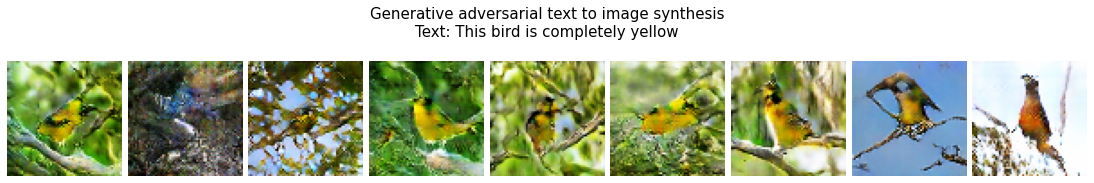

In [23]:
desc = 'This bird is completely yellow' # 'This bird is green'
#desc = 'This bird has white breast with brown feathers' # 'This bird has white breast with blue feathers'
generate_images(gen_model, generate_latent_points(100, 9, text_desc), text_desc)

## Problem 9: Image Editing with Seamless Cloning

In [254]:
import cv2
print(cv2.__version__) # make sure the major version of OpenCV is >= 3
# 3.4.3
import numpy as np
import matplotlib.pylab as plt

def plot_images(src, dst, mask, output):
    plt.figure(figsize=(20,10))
    plt.subplot(131), plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB), aspect='auto'), plt.axis('off')
    plt.title('Destination Image', size=20)
    plt.subplot(132), plt.imshow(cv2.cvtColor((0.6*src + 0.4*mask).astype(np.uint8), cv2.COLOR_BGR2RGB), aspect='auto')
    plt.axis('off'), plt.title('Source Image (with mask)', size=20)
    plt.subplot(133), plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB), aspect='auto'), plt.axis('off')
    plt.title('Output Image with Seamless Cloning', size=20)
    plt.tight_layout()
    plt.show()

4.8.0


In [ ]:
# read source and destination images
from skimage.exposure import equalize_adapthist
dst = cv2.imread("images/1.jpeg")
centers = {2:(200,350), 3:(350,745), 4:(800,125), 5:(850,750), 6:(500,125)}
# read the mask image
for i in range(2,7):
    src = cv2.imread(f"images/{i}.jpeg")
    src =  equalize_adapthist(src.astype(np.uint8))
    src = (255*src/src.max()).astype(np.uint8)
    src_mask = cv2.imread(f"images/{i}_mask.jpg")
    # this is where the CENTER of the airplane will be placed
    center = centers[i]
    # clone seamlessly.
    output = cv2.seamlessClone(src, dst, src_mask, center, cv2.NORMAL_CLONE) #cv2.NORMAL_CLONE) #cv2.MIXED_CLONE) #cv2.MONOCHROME_TRANSFER) #cv2.NORMAL_CLONE)
    #print(output.shape)
    # display result
    plot_images(src, dst, src_mask, output)
    dst = output

<img src="images/clone_in_out.png" width="500"/>

### Problem 10: Text to Image Generation and Image Editing with Dall-E OpenAI API

### 10.1 Zero-shot Text-to-image generation

In [ ]:
# pip install openai==0.28

import openai  # OpenAI Python library to make API calls
import requests  # used to download images
import os  # used to access filepaths
from PIL import Image  # used to print and edit images

# set API key
openai.api_key = 'XXXXXX'   # use your own API key here

In [ ]:
prompt = "Photo of Victoria Memorial Hall in the winter. \
         A yellow taxi is standing in front with snows over it. \
         On the right, a boy is taking selfie."

# call the OpenAI API
generation_response = openai.Image.create(
    prompt=prompt,
    n=1,
    size="1024x1024",
    response_format="url",
    style = 'natural'
)

#print(generation_response)

generated_image_name = "opeani_generated_image.png"  # any name you like; the filetype should be .png
generated_image_filepath = os.path.join('images/', generated_image_name)
generated_image_url = generation_response["data"][0]["url"]  # extract image URL from response
generated_image = requests.get(generated_image_url).content  # download the image

with open(generated_image_filepath, "wb") as image_file:
    image_file.write(generated_image)  # write the image to the file
    
#print(generated_image_filepath)
display(Image.open(generated_image_filepath))

<img src="images/openai_generated_image.png" width="500"/>

### 10.2 Editing Image with mask

<img src="images/openai_mask.png" width="500"/>

In [ ]:
prompt = "Photo of Victoria Memorial Hall in the winter. \
         A big orange cat is sitting in front. \
         On the right, a boy is taking selfie."

response = openai.Image.create_edit(
  image=open("images/openai_generated_image.png", "rb"),
  mask=open("images/openai_mask.png", "rb"),
  prompt=prompt,
  n=1,
  size="1024x1024"
)
image_url = response.data[0].url
with open('images/openai_edited_image.png','wb') as f:
    f.write(requests.get(image_url).content) # imread(image_url)
    
display(Image.open(('images/openai_edited_image.png')))

<img src="images/openai_edited_image.png" width="500"/>

### Questions

1. **Controlled** vs. **uncontrolled** deep dream: Modify the **deep dream** code with `pytorch` to work without any *control* (*guide*) image, i.e., just maximizing the activation at the sepcific layer of the **VGG16** pretrained network. Show that with the following input image the unguided vs. guided deep dream output will be like the following, if you use the following flowers image as the *control* image (for the guided deep dream), VGG16 pretrained weights and maximize the activation for layer $26$ (try changing the activation layer to be considered for gradient ascent and observe the impact on the output, e.g., what happens when shallower vs. deep leayer is chosen?). 

<img src="images/dd_disney_in.png" width="500"/>
<img src="images/deep_dream_disney_out.png" width="500"/>
<img src="images/out_dd.png" width="500"/>

2. **Deep Dream with GoogleNet (Inception V3)**: Instatiate the `inception_v3` class `torchvision.models` with pretrained weights and modify the **deep dream** code to use `inception_v3` instead of `VGG16`.  Perform deep-dreaming at the layers *Inception A, B, C, D, E* (you may need to use `pytorch` **hooks**). You may use the following code snippet to obtain the corresponding layer numbers.

In [10]:
model = models.inception_v3(pretrained=True)
l = list(model.modules())
for x in [248, 229, 190, 159, 128, 97, 84, 62, 40]:
    print(x, l[x]._get_name())

248 InceptionE
229 InceptionD
190 InceptionC
159 InceptionC
128 InceptionC
97 InceptionC
84 InceptionB
62 InceptionA
40 InceptionA


You should obtain an output like the following figure, with an input image of a sky:

<img src="images/deep_dream_cloud_out.png" width="500"/>

3. Compare and show the output of the colored images obtained using different colorization algorithms for the same grayscale images. You should obtain a figure like the following one. for the given input images (hint: you may want to implement couple of `python` functions `get_deoldify_output()` and `get_cic_output()`):

<img src="images/colorized_out.png" width="500"/>

4. Tune the `render_factor` hyperparameter of the *DeOldify* algorithm (e.g., change from $20$ to $40$) and observe the impact on the color image generated, starting from the following input grayscale image given. 

<img src="images/Img_02_13.jpg" width="300"/>
 
You should obtain a figure like the following one, for different values of `render_factor`, in increasing order.

<img src="images/deoldify_render.png" width="500"/>
    
   Compare the colorized output images obtained using different versions (`artistic`, `stable` etc.) the *deoldify* colorizer outputs. Extract frames from a black-and-white (grayscale) video and colorize with different versions.
    
   Now, start with a color image (ground truth). Convert it to a grayscale image and automatically color the image using above alogirthms.  Compute the **Raw accuracy** (as defined here: https://arxiv.org/pdf/1603.08511.pdf), defined by the percentage of predicted pixel colors within a thresholded $L_2$ distance (choose a threshold between $0$ to $150$) of the ground truth in *ab* color space (convert **RGB** to **Lab**).

5. Use the library `neural-style` to obtain stylized image with *NST* starting with a content and a style input image. Note that it uses iterative update to modify the output image, so you should run on *GPU*, otherwise it will be very slow (hint: use the following commands to setup the library and download the models). You should obtain an output as shown in the next figure with the given content (metor) and style (Van Gogh's *starry night*) image. Note the command line arguments used, many of them are hyperparameters to the model (e.g., `content_weight`, `style_weight`, `optimizer`), tweak them to observe the impact on the generated image.

In [ ]:
#!pip install neural-style
#!neural-style -download_models models/
!neural-style -style_image starry_night.jpg -content_image metro.png -output_image output.png -model_file nin_imagenet.pth \
              -gpu 0 -backend cudnn -num_iterations 1000 -seed 123 -content_layers relu0,relu3,relu7,relu12 \
              -style_layers relu0,relu3,relu7,relu12 -content_weight 10 -style_weight 500 -image_size 512 -optimizer adam

<img src="images/metro_starry.png" width="300"/>
   
   Next, use it to combine multiple style images with a content image, you should obtain a figure like the following, once you start with the inputs shown.

<img src="images/lion_hwh.png" width="300"/>

Refer to this paper https://arxiv.org/pdf/1703.06953.pdf (that introduces a *CoMatch* Layer which learns to match the second order feature statistics with the target styles) and this `pytorch` implementation https://github.com/zhanghang1989/PyTorch-Multi-Style-Transfer to implement *multi-style generative netowrk* (*MSGNet*). Start with an image of a train as *content* and the candy *style* image to obtain the following output image with *artistic style transfer*, shown in the next figure:

<img src="images/style_msg_out.png" width="300"/>
   Finally, use *MSG-Net* for much faster inference and better quality stylized output image, with multiple style images. 

6. Image to Video with Stable Video Diffusion: Use pretrained stable video diffusion model from HuggingFace to create video from an image.

In [ ]:
import torch
#from diffusers import DiffusionPipeline
from diffusers.pipelines.pipeline_utils import DiffusionPipeline
from diffusers.utils import load_image, export_to_video

# Load the pipeline
pipeline = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid",
    torch_dtype=torch.float16,
    variant="fp16"
).to("cuda")

pipeline.enable_model_cpu_offload()

# Load and preprocess the image
image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/svd/rocket.png")
image = image.resize((1024, 576))

# Generate video frames
generator = torch.manual_seed(42)
frames = pipeline(image, decode_chunk_size=8, generator=generator, num_frames=25).frames[0]

# Export to video
export_to_video(frames, "generated.mp4", fps=7)

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 1.13.1+cu117 with CUDA 1107 (you have 2.4.1+cu118)
    Python  3.8.10 (you have 3.8.19)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
C:\Users\sandi\anaconda3\envs\torch-gpu\lib\site-packages\xformers\ops\swiglu_op.py:78: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(cls, ctx, x, w1, b1, w2, b2, w3, b3):
C:\Users\sandi\anaconda3\envs\torch-gpu\lib\site-packages\xformers\ops\swiglu_op.py:99: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., d

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\sandi\anaconda3\envs\torch-gpu\lib\site-packages\transformers\models\clip\modeling_clip.py:540: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


  0%|          | 0/25 [00:00<?, ?it/s]

### References

1. https://arxiv.org/pdf/1705.06830.pdf
2. https://arxiv.org/pdf/1603.08511.pdf
3. https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf
4. https://www.ipol.im/pub/art/2022/403/article_lr.pdf
5. https://www.researchgate.net/publication/329610370_Hands-on_Image_Processing_in_Python
6. https://github.com/jantic/DeOldify
7. https://github.com/onnx/models/tree/main/vision/style_transfer/fast_neural_style
8. https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf
9. https://cs.gmu.edu/~xzhou10/doc/kinect-study.pdf
10. https://arxiv.org/pdf/2103.13413.pdf
11. https://github.com/AloneTogetherY/text-to-image-synthesis
12. https://bitesofcode.wordpress.com/2018/09/16/augmented-reality-with-python-and-opencv-part-2/
13. https://www.cs.jhu.edu/~misha/Fall07/Papers/Perez03.pdf
14. http://proceedings.mlr.press/v48/reed16.pdf
15. https://arxiv.org/pdf/1903.05628.pdf
14. https://www.youtube.com/watch?v=cwe0nBqkDWk
15. https://www.youtube.com/watch?v=98ZYF9M-4Js
16. https://www.youtube.com/shorts/hpaaT5yaaeE
17. https://www.youtube.com/watch?v=bxzuCmcHlO4
18. https://www.youtube.com/watch?v=d2CSrDKs6Jw
19. https://www.youtube.com/watch?v=XBTaE32-wL4
20. https://www.youtube.com/watch?v=eL33bEyy88o
21. https://www.youtube.com/watch?v=4-_Fc5S4rNE
22. https://www.youtube.com/watch?v=qdDlW4g9Yik
23. https://www.youtube.com/watch?v=QFml23buJqQ
24. https://www.youtube.com/watch?v=23nHljrSh3I
25. https://www.youtube.com/watch?v=8mWaFrCFdCw
28. https://arxiv.org/abs/2102.12092